## In this File, we make use of a Multilayer Perceptron to classify the popular MNIST data set

In [22]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
batch_size = 20
num_workers = 0

In [3]:
trainset = datasets.MNIST('MNIST_data/', download=True, transform=transform)
testset = datasets.MNIST('MNIST_data/', download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [4]:
# We view the shape of the images in the trainloader
images, labels = next(iter(trainloader))
images[0].shape

torch.Size([1, 28, 28])

# Functionalize Viewing 20 images in a batch and their labels

In [5]:
def view_images(images):
    fig, ax = plt.subplots(figsize=(10, 6), nrows=4, ncols=5)
    for i in range(4):
        for j in range(5):
            idx = i * 5 + j
            ax[i, j].imshow(np.squeeze(images[idx]), cmap='gray') 
            ax[i, j].set_title(str(int(labels[idx])))
            ax[i, j].axis('off')  # Optional: Turn off axis for better visualization
    return plt.show()


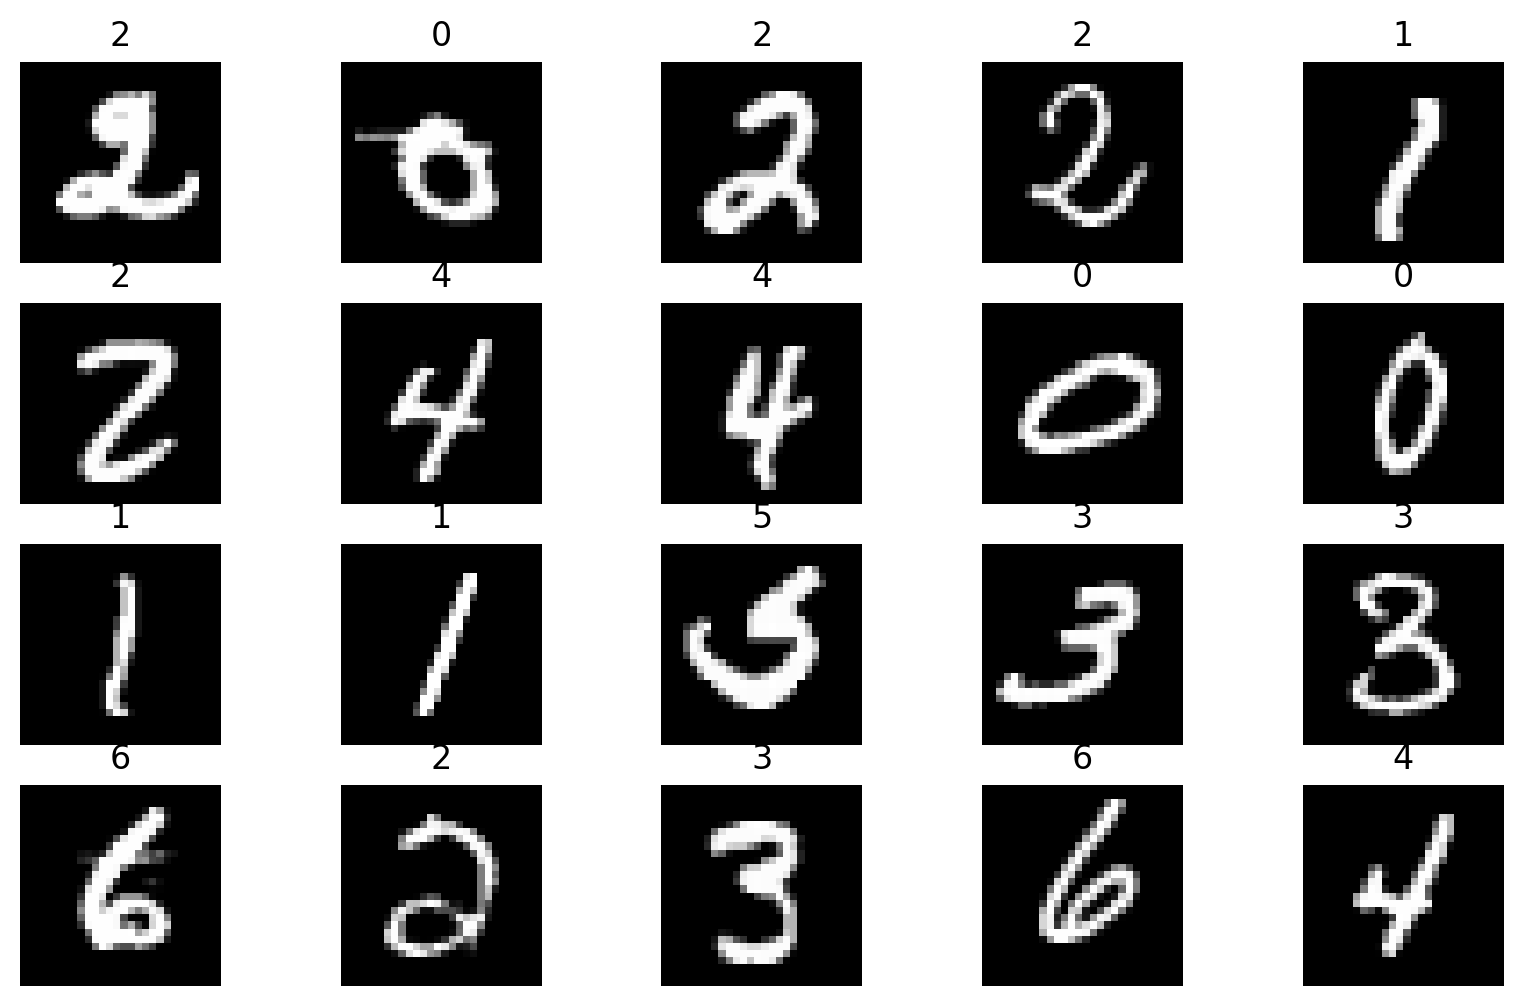

In [6]:
view_images(images)

In [16]:
# Define the Architecture of my multi layer perceptron
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(p=0.2) # Add a dropout layer to prevent overfitting
    def forward(self, x):
        x = x.view(-1, 784) # Flatten the image so it can enter the first feed forward layer
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [17]:
model = Network()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [18]:
epochs = 40
running_loss_array, testing_loss_array = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss = running_loss + loss.item()*images.size(0)
    testing_loss = 0
    test_correct = 0 # to calculate the number of correct prediction
    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            logps = model(images)
            loss = criterion(logps, labels)
            testing_loss = testing_loss + loss.item()*images.size(0)
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_correct += torch.mean(equals.type(torch.FloatTensor)).item()
    model.train()
    running_loss = running_loss/len(trainloader.dataset)
    testing_loss = testing_loss/len(trainloader.dataset)
    running_loss_array.append(running_loss) 
    testing_loss_array.append(testing_loss)
    test_correct = test_correct/len(testloader)
    print(
        f'epoch {e+1}/{epochs}.. Training Loss: {running_loss}.. Testing Loss: {testing_loss}.. Testing Accuracy: {(test_correct)*100:.2f}%'
    )

epoch 1/40.. Training Loss: 1.6556002208987872.. Testing Loss: 0.7418703845043977.. Testing Accuracy: 82.44%
epoch 2/40.. Training Loss: 0.5787355992446344.. Testing Loss: 0.42725696267187596.. Testing Accuracy: 88.35%
epoch 3/40.. Training Loss: 0.4262732493206859.. Testing Loss: 0.35372053128356734.. Testing Accuracy: 90.03%
epoch 4/40.. Training Loss: 0.36891270774106183.. Testing Loss: 0.3141416146165381.. Testing Accuracy: 91.08%
epoch 5/40.. Training Loss: 0.3328598249728481.. Testing Loss: 0.28597792780337233.. Testing Accuracy: 91.86%
epoch 6/40.. Training Loss: 0.304351379427438.. Testing Loss: 0.26365936214414737.. Testing Accuracy: 92.43%
epoch 7/40.. Training Loss: 0.28001730097209415.. Testing Loss: 0.24318245002503197.. Testing Accuracy: 92.97%
epoch 8/40.. Training Loss: 0.26141643576634427.. Testing Loss: 0.22621037453319878.. Testing Accuracy: 93.43%
epoch 9/40.. Training Loss: 0.24407463235966861.. Testing Loss: 0.2100669021513313.. Testing Accuracy: 93.99%
epoch 10/4

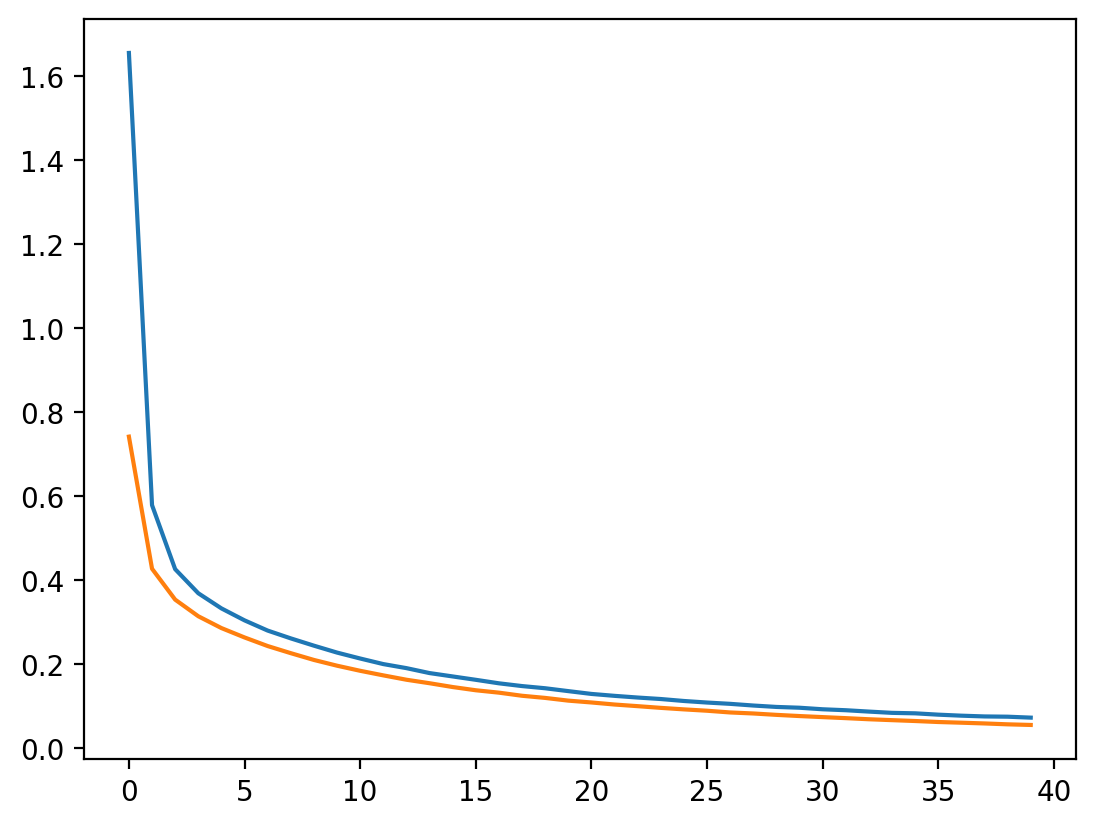

In [31]:
plt.plot(running_loss_array, label='training loss')
plt.plot(testing_loss_array, label='testing loss')
plt.show()
# This plot shows how the training and testing losses are reducing equally hence, the model is learning and not generalizing nor overfitting

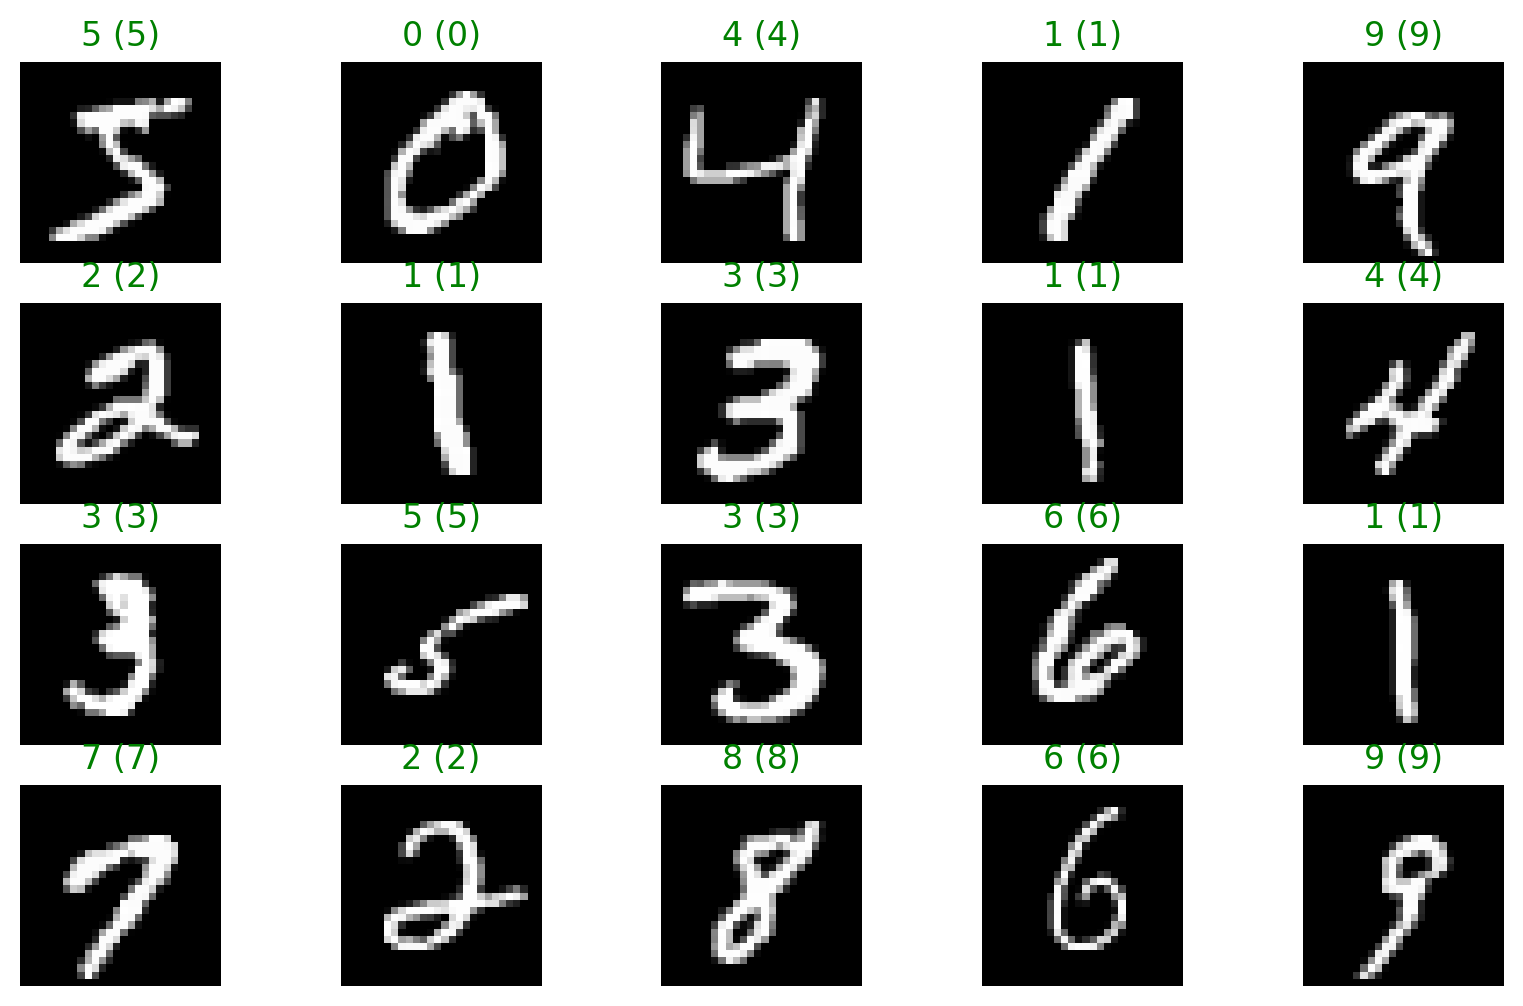

In [32]:
images, labels = next(iter(testloader))

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig, ax = plt.subplots(figsize=(10, 6), nrows=4, ncols=5)
for i in range(4):
    for j in range(5):
        idx = i * 5 + j
        ax[i, j].imshow(np.squeeze(images[idx]), cmap='gray')
        ax[i, j].set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))
        ax[i, j].axis('off')

# Training the network using a validation dataset

In [33]:
valid_size = 0.2
batch_size = 20
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


In [36]:
train_sample = SubsetRandomSampler(train_idx)
valid_sample = SubsetRandomSampler(valid_idx)
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sample, num_workers=num_workers)
validloader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sample, num_workers=num_workers)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=num_workers)

In [57]:
epochs=20
valid_loss_min = np.Inf
for e in range(epochs):
    running_loss = 0
    validation_loss = 0
    for  images, labels in trainloader:
        logps = model(images)
        loss = criterion(logps, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss = running_loss + loss.item()*images.size(0)
    for images, labels in validloader:
        logps = model(images)
        loss = criterion(logps, labels)
        validation_loss = validation_loss + loss.item()*images.size(0)
    running_loss = running_loss/len(trainloader.dataset)
    validation_loss = validation_loss/len(validloader.dataset)
    print(
        f'{e+1}/{epochs} gives an average training loss of {running_loss} and average validation loss of {validation_loss}'
    )
    if validation_loss <= valid_loss_min:
        print(
            f'the validation loss decreased: {valid_loss_min:.6f} --> {validation_loss:.6f}. Saving model'
        )
        torch.save(model.state_dict(), 'model.pth')
        valid_loss_min = validation_loss

1/20 gives an average training loss of 0.026277894803031814 and average validation loss of 0.010519052609083398
the validation loss decreased: inf --> 0.010519. Saving model
2/20 gives an average training loss of 0.02551011889008805 and average validation loss of 0.010511799237380425
the validation loss decreased: 0.010519 --> 0.010512. Saving model
3/20 gives an average training loss of 0.02490298409271054 and average validation loss of 0.010393797371264857
the validation loss decreased: 0.010512 --> 0.010394. Saving model
4/20 gives an average training loss of 0.024180682005593552 and average validation loss of 0.010374340517194165
the validation loss decreased: 0.010394 --> 0.010374. Saving model
5/20 gives an average training loss of 0.023464120327320415 and average validation loss of 0.010355548975019094
the validation loss decreased: 0.010374 --> 0.010356. Saving model
6/20 gives an average training loss of 0.022918292510536654 and average validation loss of 0.010289111046722003


In [38]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [155]:
epochs = 50
for e in range(epochs):
    testing_loss = 0
    test_correct = 0
    for images, labels in testloader:
        logps = model(images)
        loss = criterion(logps, labels)
        testing_loss = testing_loss + loss.item()*images.size(0)
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_correct += torch.mean(equals.type(torch.FloatTensor)).item()
    testing_loss = testing_loss/len(testloader.dataset)
    print(
        f'{e+1}/{epochs} gives an average loss of {testing_loss} and an accuracy of {test_correct/len(testloader)}'
    )

1/50 gives an average loss of 0.07057784948412639 and an accuracy of 0.9792499957283338
2/50 gives an average loss of 0.07024249261314981 and an accuracy of 0.9796833290060362
3/50 gives an average loss of 0.0709051793073498 and an accuracy of 0.9790333290100097
4/50 gives an average loss of 0.07063828804810571 and an accuracy of 0.9791166622440021
5/50 gives an average loss of 0.0704694399383346 and an accuracy of 0.9787833288113276
6/50 gives an average loss of 0.07080410565283576 and an accuracy of 0.9792666623393694
7/50 gives an average loss of 0.07047115053131711 and an accuracy of 0.9799833290974299
8/50 gives an average loss of 0.07139623749054347 and an accuracy of 0.9789166622161866
9/50 gives an average loss of 0.06976012448950981 and an accuracy of 0.9792499955097834
10/50 gives an average loss of 0.06973294105520472 and an accuracy of 0.9797833289901415
11/50 gives an average loss of 0.07159210320333174 and an accuracy of 0.9794333290060361
12/50 gives an average loss of 0

## So the model performed just as well with a validation set

In [54]:
## So i want do download an image from the Internet and test it against the trained model
test_transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize the image to match the training size
    transforms.ToTensor(),        # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values (assuming grayscale)
])


Predicted Digit: 7


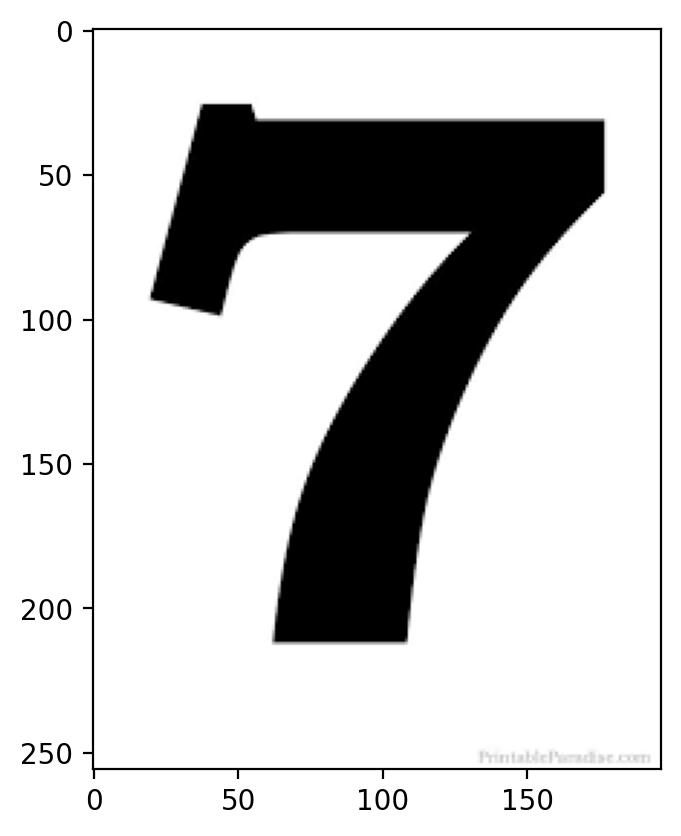

In [62]:
img1 = Image.open('7.png')
plt.imshow(img1)
input_tensor = test_transform(img1)
input_tensor = input_tensor.unsqueeze(0)
model.eval()
with torch.no_grad():
    logps = model(input_tensor)
    ps = torch.exp(logps)
predicted_class = torch.argmax(ps).item()

# Now 'predicted_class' contains the predicted digit
print("Predicted Digit:", predicted_class)